# Climate Model: Carbon Cycle and Temperature Dynamics

This notebook implements a **reduced-form climate model** inspired by DICE-type frameworks.  
It tracks the dynamics of atmospheric carbon, ocean carbon, radiative forcing, and temperature.  
The time step is `Δ` years (annual or 5-year), starting at year `t0`.

---

## State Variables
- **E(t)** : Exogenous CO₂ emissions (GtC per year)  
- **M_AT(t)** : Carbon mass in the atmosphere (GtC)  
- **M_UP(t)** : Carbon mass in the upper ocean (GtC)  
- **M_LO(t)** : Carbon mass in the lower ocean (GtC)  
- **F(t)** : Radiative forcing (W/m²)  
- **T_AT(t)** : Atmospheric temperature anomaly (°C)  
- **T_LO(t)** : Lower-ocean temperature anomaly (°C)  

---

## Carbon Cycle Equations

$$
M_{AT}(t) = (1 - \Delta b_{12}) M_{AT}(t-1) 
+ \Delta b_{12} \frac{M_{AT0}}{M_{UP0}} M_{UP}(t-1) 
+ \xi E(t-1)
$$

$$
M_{UP}(t) = \Delta b_{12} M_{AT}(t-1) 
+ \left(1 - \Delta b_{12} \tfrac{M_{AT0}}{M_{UP0}} - \Delta b_{23}\right) M_{UP}(t-1) 
+ \Delta b_{23} \frac{M_{UP0}}{M_{LO0}} M_{LO}(t-1)
$$

$$
M_{LO}(t) = \Delta b_{23} M_{UP}(t-1) 
+ \left(1 - \Delta b_{23} \tfrac{M_{UP0}}{M_{LO0}}\right) M_{LO}(t-1)
$$


---

## Radiative Forcing

$$
F(t) = F_{2 \times CO_2} \cdot 
\frac{\ln\!\left(\tfrac{M_{AT}(t-1)}{M_{AT}^{\text{pre}}}\right)}{\ln(2)}
$$

where  
- $F_{2 \times CO_2}$ is the forcing from doubling CO₂ (≈ 3.36 W/m²),  
- $M_{AT}^{\text{pre}}$ is preindustrial atmospheric carbon mass.  

---

## Temperature Dynamics

$$
T_{AT}(t) = T_{AT}(t-1) 
+ \Delta c_1 \, F(t) 
- \Delta c_1 \, \frac{F_{2 \times CO_2}}{T_{2 \times CO_2}} \, T_{AT}(t-1) 
- \Delta c_1 c_3 \, \big( T_{AT}(t-1) - T_{LO}(t-1) \big), $$

$$
T_{LO}(t) = T_{LO}(t-1) 
+ \Delta c_4 \, \big( T_{AT}(t-1) - T_{LO}(t-1) \big).
$$

---

## Key Parameters
- $\Delta$: time step (years)  
- $F_{2 \times CO_2}$: forcing for CO₂ doubling  
- $T_{2 \times CO_2}$: equilibrium climate sensitivity (°C per doubling)  
- $b_{12}, b_{23}$: carbon transfer rates (atmosphere ↔ ocean)  
- $c_1, c_3, c_4$: heat transfer coefficients  
- $\xi$: conversion factor CO2 to C.

---

## Purpose
This notebook will:
1. Initialize the state variables at year `t0`.  
2. Simulate carbon and temperature dynamics over time.  
3. Explore the effect of emissions scenarios on climate trajectories.  

---


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import Climate_Models as CM

# A — Historical Climate Dynamics

In this section, we will work with **historical CO₂ emissions data** collected by *Our World in Data*.  
The dataset provides **annual CO₂ emissions by country** (measured in tonnes of CO₂) starting from the Industrial Revolution.


In [7]:
import pandas as pd
import requests

# Fetch the data.
df = pd.read_csv("https://ourworldindata.org/grapher/annual-co2-emissions-per-country.csv?v=1&csvType=full&useColumnShortNames=true", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})

# Fetch the metadata
metadata = requests.get("https://ourworldindata.org/grapher/annual-co2-emissions-per-country.metadata.json?v=1&csvType=full&useColumnShortNames=true").json()


In [9]:
# Select World data
df_world = df[df["Entity"] == "World"]

# Or using the code column
df_world = df[df["Code"] == "OWID_WRL"]

# Convert into Tons into GtCO2
world_co2 = df_world["emissions_total"]/(10**9)
year_co2  = df_world["Year"]
print(df_world.head())

      Entity      Code  Year  emissions_total
28837  World  OWID_WRL  1750        9305937.0
28838  World  OWID_WRL  1751        9407229.0
28839  World  OWID_WRL  1752        9505168.0
28840  World  OWID_WRL  1753        9610490.0
28841  World  OWID_WRL  1754        9733580.0


### A-1) plot the paths of carbon emissions

C:\Users\gauth\AppData\Local\Temp\ipykernel_23108\896569621.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.xlabel("Year"); plt.grid(True); plt.legend()


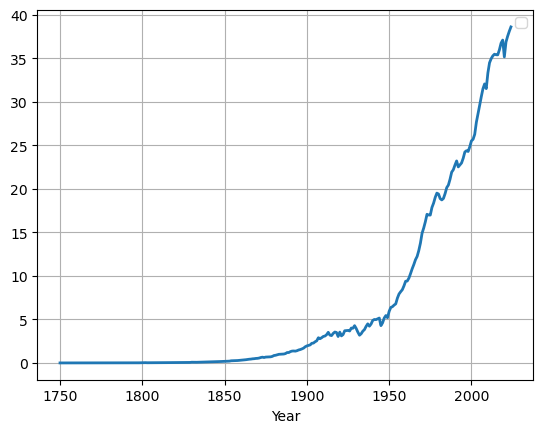

In [11]:

plt.figure()
plt.plot(year_co2,world_co2, linewidth=2)
plt.xlabel("Year"); plt.grid(True); plt.legend()
plt.show()

### A-2) We would like to simulate climate dynamics

#### Initializing the Climate System

Before we can simulate climate dynamics, we must **set the model at its pre-industrial equilibrium**.  
This means starting the system in the state it was around the year 1750, before large-scale industrial CO₂ emissions began.

- **Carbon stocks** are initialized at their **pre-industrial levels**:  
  - $M_{AT0} = M_{AT}^{\text{pre}}$ (atmosphere)  
  - $M_{UP0} = M_{UP}^{\text{pre}}$ (upper ocean)  
  - $M_{LO0} = M_{LO}^{\text{pre}}$ (lower ocean)  

- **Temperature anomalies** are set to **zero** at the start:  
  - $T_{AT0} = 0$ (no atmospheric anomaly)  
  - $T_{LO0} = 0$ (no ocean anomaly)  

- The **time horizon** spans from 1749 to 2020 with annual steps.

**Exercise:**
1. What is the path of atmospheric carbon `M_AT` and temperature `T_AT`? Use a plot.
2. Quickly comment your outcome.

In [ ]:
# Your code
pass

> ✍️ You written answer here.

### A-3) Feed the climate system with carbon emissions

**Goal**

We’ll (i) load historical CO₂ emissions, (ii) convert them to the model’s units (GtC/year), (iii) inject them into the simulation matrix `path[:, i_E]`, (iv) update the climate path, and (v) plot and comment.

---

**Exercise**

1. Replace the emissions in `path[:, p.i_E]` by `world_co2` aligned by year (already done above) and run:
   ```python
   CM.update_path(path, p, 1750, 2020)
2. Plot the result in term of carbon accumulation and global atmospheric temperature.


270


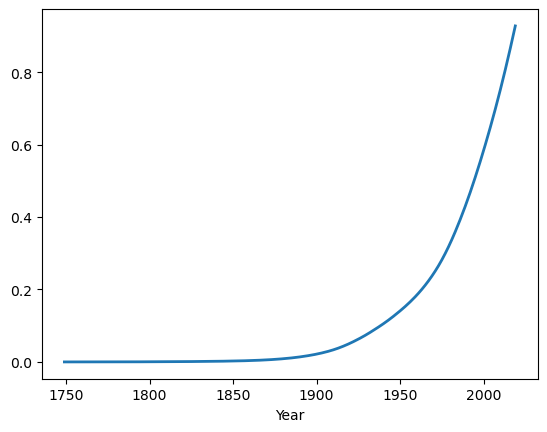

In [44]:
# Your code here.
year_co2       = year_co2.reset_index(drop=True)
world_co2      = world_co2.reset_index(drop=True)
tt             = np.where(year_co2 == 2020)[0][0]
path_pollution = path.copy()

pass
path_pollution[2:,p.i_E] = world_co2[0:tt]

path_pollution = CM.update_path(path_pollution,p,1750,2020)

plt.figure()
plt.plot(path_pollution[:,p.i_time],path_pollution[:,p.i_T_AT], linewidth=2)
plt.xlabel("Year");
plt.show()


### A-4) Plot and comment: global temperature anomalies

**Goal**

Compare observed global near-surface temperature anomalies with the model-simulated atmospheric temperature anomaly obtained from historical emissions. Discuss similarities and differences in terms of level, trend, and variability.

---

**Instructions**

1. **Line plot (comparison).**  
   Plot `world_temp` against `world_temp_yr` (observed series) together with `path_pollution[:, p.i_T_AT]` (simulated series under historical emissions).  
   Make sure both are aligned by calendar year.  
   Label axes, add a legend, title, and grid.

2. **Basic diagnostics.**  
   - Comment how well the simulated path reproduces the observed warming trend.  
   - Discuss differences in the early period vs. recent decades.  
   - Note that the observed series includes short-term variability (ENSO, volcanoes) not captured by the simple model.  
   - Reflect on whether the model underestimates or overestimates the magnitude of warming.


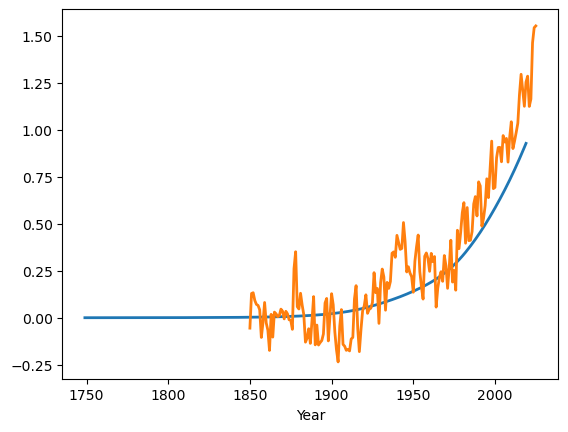

In [48]:
import pandas as pd
import requests

# Fetch the data.
temperatures_data = pd.read_csv("https://ourworldindata.org/grapher/temperature-anomaly.csv?v=1&csvType=full&useColumnShortNames=true", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})

# Select column World
temperatures_world = temperatures_data[temperatures_data["Code"] == "OWID_WRL"]

# Select year and global temperatures
world_temp    = temperatures_world["near_surface_temperature_anomaly"]
world_temp    = world_temp.reset_index(drop=True)
world_temp_yr = temperatures_world["Year"]
world_temp_yr = world_temp_yr.reset_index(drop=True)

pass
# Continue to code here
plt.figure()
plt.plot(path_pollution[:,p.i_time],path_pollution[:,p.i_T_AT], linewidth=2)
plt.plot(world_temp_yr,world_temp, linewidth=2)
plt.xlabel("Year");
plt.show()

> ✍️ You written answer here.

### A-5) Methane cycles

**Goal**

Extend the climate model to account for methane (CH₄), which has a shorter lifetime than CO₂ but a stronger warming potential per molecule. Methane dynamics can be represented by a simple decay equation and its radiative forcing contribution.

---

**Methane cycle (one-box model)**

Methane accumulates through emissions and decays with a characteristic lifetime of about 12 years:

$$
M_{CH4}(t) = (1 - \delta \cdot \Delta) \, (M_{CH4}(t-1)  - m_{CH4} ) + \Delta \cdot E_{CH4}(t)
$$

- $M_{CH4}(t)$: atmospheric methane concentration (ppb).  
- $E_{CH4}(t)$: methane emissions (in ppb equivalents).  
- $\delta \approx 1/12$: annual decay rate.  
- $\Delta$: time step (1 year).
- $m_{CH4}$: preindustrial level of methan. 

---

**Radiative forcing from methane**

Methane’s forcing is approximately proportional to the square root of its concentration:

$$
F_{CH4}(t) = \alpha_{CH4}\,\Big(\sqrt{M_{CH4}(t)} - \sqrt{M_{CH4,0}}\Big)
$$

- $M_{CH4,0} \approx 722$ ppb (pre-industrial baseline).  
- $\alpha_{CH4} \approx 0.036 \,\text{W/m}^2 / \sqrt{\text{ppb}}$.  

---

**Total forcing**

The climate system now responds to combined forcing:

$$
F(t) = F_{CO2}(t) + F_{CH4}(t) + F_{\text{ex}}(t)
$$

where $F_{\text{ex}}$ (set to zero) can capture other greenhouse gases or exogenous forcing.

---

**Implementation hints**

- Download Methan data.
- Feed the model with methan data.
- Update `update_path` to simulate both the methane stock and its forcing.

---

**Questions**

- Compare Global temperature, atmospheric methan and carbon into a subplot `1*3`.
- Comment your results.

---


      Entity      Code  Year  annual_emissions_n2o_total_co2eq  \
40542  World  OWID_WRL  1850                      1.448322e+08   
40543  World  OWID_WRL  1851                      1.474454e+08   
40544  World  OWID_WRL  1852                      1.500012e+08   
40545  World  OWID_WRL  1853                      1.524642e+08   
40546  World  OWID_WRL  1854                      1.547989e+08   
...      ...       ...   ...                               ...   
40711  World  OWID_WRL  2019                      2.869841e+09   
40712  World  OWID_WRL  2020                      2.909539e+09   
40713  World  OWID_WRL  2021                      2.949630e+09   
40714  World  OWID_WRL  2022                      2.975719e+09   
40715  World  OWID_WRL  2023                      2.996286e+09   

       annual_emissions_ch4_total_co2eq  annual_emissions_co2_total  
40542                      1.239410e+09                2.834819e+09  
40543                      1.244053e+09                3.017812e+09

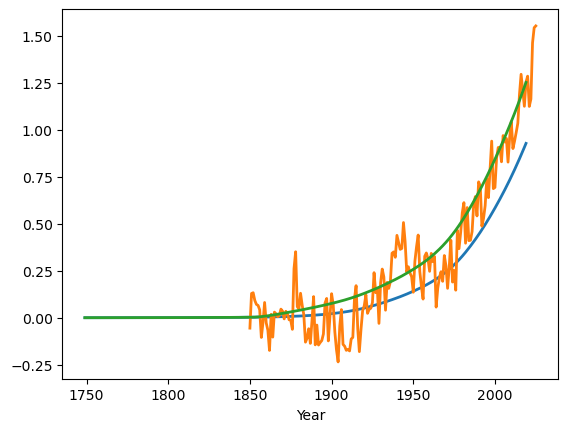

In [62]:
#Your code here
import pandas as pd
import requests

# Fetch the data.
df_ch4 = pd.read_csv("https://ourworldindata.org/grapher/ghg-emissions-by-gas.csv?v=1&csvType=full&useColumnShortNames=true", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})
df_ch4_world = df_ch4[df_ch4["Entity"] == "World"]

print(df_ch4_world)

# Convert ton equivalent tEqCO2 = tCH4*29.8
#                        Mt     = 10^6 tons
#                        ppb    = 2.78*Mt
world_ch4 = df_ch4_world["annual_emissions_ch4_total_co2eq"]/(10**6 * 29.8 * 2.78)
year_ch4  = df_ch4_world["Year"]

# Drop indices
year_ch4       = year_ch4.reset_index(drop=True)
world_ch4      = world_ch4.reset_index(drop=True)
tTmh4          = np.where(year_ch4 == 2020)[0][0]
path_ch4_co2   = path_pollution.copy()

pass
print(year_ch4)
path_ch4_co2[102:,p.i_E_CH4] = world_ch4[0:tTmh4]
path_ch4_co2 = CM.update_path(path_ch4_co2,p,1750,2020)

plt.figure()
plt.plot(path_pollution[:,p.i_time],path_pollution[:,p.i_T_AT], linewidth=2)
plt.plot(world_temp_yr,world_temp, linewidth=2)
plt.plot(path_ch4_co2 [:,p.i_time],path_ch4_co2 [:,p.i_T_AT], linewidth=2)
plt.xlabel("Year");
plt.show()

> ✍️ You written answer here.

# B — Forecasting temperatures based on SSP scenarios

**Goal**

Use IPCC’s *Shared Socioeconomic Pathways (SSPs)* as alternative futures for carbon emissions and examine how the climate system responds.  
We start from emissions trajectories that are provided on a **decadal grid** and interpolate them to an **annual grid** to be compatible with our climate model.

**Data source**

[Our World in Data – IPCC scenarios explorer](https://ourworldindata.org/explorers/ipcc-scenarios?Metric=Greenhouse+gas+emissions&Sub-metric=Carbon+dioxide+%28CO%E2%82%82%29&Region=Global&country=SSP1+-+Baseline~SSP2+-+Baseline~SSP3+-+Baseline~SSP4+-+Baseline~SSP5+-+Baseline)

This dataset contains baseline CO₂ emissions paths for the five SSPs:

- **SSP1 (Sustainability)**  
- **SSP2 (Middle of the road)**  
- **SSP3 (Regional rivalry)**  
- **SSP4 (Inequality)**  
- **SSP5 (Fossil-fueled development)**  

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

# Load
df = pd.read_csv("Notebook_ClimateModels_SSP_data.csv",sep=";",decimal=",")

# Pick year + SSP columns
year = df["Year"]

# Plot
plt.figure
plt.plot(year, df["SSP1"], label="SSP1",color="#1B9E77")
plt.plot(year, df["SSP2"], label="SSP2",color="#D95F02")
plt.plot(year, df["SSP3"], label="SSP3",color="#8C6D31")
plt.plot(year, df["SSP4"], label="SSP4",color="#2CA25F")
plt.plot(year, df["SSP5"], label="SSP5",color="#6F42C1")
plt.grid(True, alpha=0.3)
plt.legend(title="Scenario", ncol=2, frameon=False)
plt.title("Per capita CO₂ emissions — SSP baselines (global)")
plt.xlabel("Year"); plt.ylabel("CO₂ per capita")
plt.tight_layout();
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'Notebook_ClimateModels_SSP_data.csv'

### B-1) Simulate temperature paths under SSP scenarios

**Goal**

Use the interpolated SSP emissions from **2020 to 2100** as inputs to the climate model, simulate the atmospheric temperature anomaly (`T_AT`), and compare the resulting warming trajectories.

---

**Instructions**

1. Initialize the model at year 2020 using the last state from the historical simulation.  
2. For each SSP scenario, fill the emissions column (`E`) in the simulation matrix from 2020 to 2100 with the interpolated annual values.  
3. Run the climate model update routine (`CM.update_path`).  
4. Plot the resulting **temperature anomalies** for all SSPs together.

---

**Questions**
1. Comment your simulated path in terms of temperatures for different SSPs.


---


In [ ]:
# Your code here
# create main calibration (default)
p2       = CM.Params()
    
# Time definitions
p2.Delta = 1         # Annual Data
p2.t0    = 1749      #
p2.tT    = 2100
p2.nT    = (p2.tT + p2.Delta - p2.t0)//p.Delta # update number of periods
    
# Initialize to pre-industrial carbon
p2.M_AT0 = p.mat
p2.M_UP0 = p.mup
p2.M_LO0 = p.mlo
# No Temperatures anomalies
p2.T_AT0 = 0
p2.T_LO0 = 0

# Initialize the matrix Time x Variables and initialize state variables
path_SSP = CM.init_states(p2)

print(path_SSP)
# By default: there are no emissions 
# Update the model (with no emissions)
path_SSP = CM.update_path(path_SSP,p2,1750,2020)

path_SSP1 = path_SSP.copy()
path_SSP2 = path_SSP.copy()
path_SSP3 = path_SSP.copy()
path_SSP4 = path_SSP.copy()
path_SSP5 = path_SSP.copy()

pass

> ✍️ You written answer here.